In [4]:
import pathlib
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import copy

In [5]:
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
device = torch.device("cpu")

class ImageDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        labels = np.asarray([dataset[i][1] for i in range(len(dataset))])
        data = np.asarray([dataset[i][0] for i in range(len(dataset))])
        
        self.img_labels = torch.from_numpy(labels)
        self.img_labels = self.img_labels.to(device)
        
        data = np.moveaxis(data, 3, 1)
        self.img_data = torch.from_numpy(data)
        self.img_data = self.img_data.to(device)
        self.transform = transform
        self.target_transform = target_transform
        

    def __len__(self):
        # return 10-times the size of the dataset because it is small and the augmentation is quite strong
        return len(self.img_labels)*10  

    def __getitem__(self, idx):
        idx = idx % len(self.img_labels)
        image = self.img_data[idx]
        
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

### Now load the images / data

In [6]:
X_train = list()
y_train = list()

for file in pathlib.Path("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/pfannkuchen").iterdir():
    if file.is_file() and file.suffix == ".bmp":
        pic = Image.open("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/pfannkuchen/" + file.name)
        pix = np.asarray(pic)
        pix = pix / 255.0
        pix = pix.astype(np.float32)
        
        X_train.append(pix)
        y_train.append(1)
        
length = len(X_train)

for file in pathlib.Path("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/berliner").iterdir():
    if file.is_file() and file.suffix == ".bmp":
        pic = Image.open("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/berliner/" + file.name)
        pix = np.asarray(pic)
        pix = pix / 255.0
        pix = pix.astype(np.float32)
        
        
        X_train.append(pix)
        y_train.append(0)
        if len(X_train) >= length*2:
            break #prevent one class from being overrepresented

### Split the data into train-,validatn- and testsets

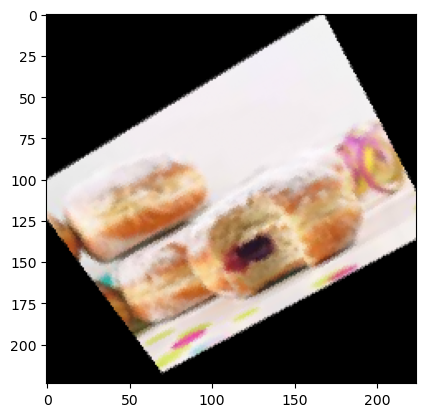

In [7]:
from torchvision import datasets, models, transforms

complete_dataset = np.asarray([[X_train[i].repeat(2,axis=0).repeat(2, axis=1), y_train[i]] for i in range(len(X_train))], dtype=object)

total_count = len(X_train)
train_count = int(0.7 * total_count)
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count


train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    complete_dataset, (train_count, valid_count, test_count)
)

trainset = ImageDataset(train_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))

testset = ImageDataset(test_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))

validset = ImageDataset(valid_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))


data, lbl = trainset.__getitem__(400)
data = np.asarray(data)
data = np.moveaxis(data, 0, 2)

plt.imshow(data) 
plt.show()

### Define function train_model to do all the hard training work

In [8]:
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

def train_model(model, optimizer, criterion=nn.CrossEntropyLoss(), epoch_count=10, batch_size=50):
    torch.manual_seed(42)
    best_acc = 0.0
    
    train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=0)

    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    val_accuracys = []
    running_loss = []

    for epoch in range(epoch_count):  # loop over the dataset multiple times
        model.train(True)
        train_progress  = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", mininterval=0.3)
        for i, data in enumerate(train_progress, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            
            # print statistics
            running_loss.append(loss.item())
            train_progress.set_description(f"Epoch: {epoch+1}, loss: {loss.item():.3}")
        
        model.train(False)
        print(f"------ Epoch {epoch+1} ------")
    
        val_loss = 0
        val_accuracy = 0
        for i, data in enumerate(valid_dataloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += (outputs.argmax(dim=1) == labels).type(torch.float).mean().item()
        val_loss = val_loss / len(valid_dataloader)
        val_accuracy = val_accuracy / len(valid_dataloader)
        
        val_accuracys.append(val_accuracy)
        val_losses.append(val_loss)
        train_losses.append(sum(running_loss)/(len(running_loss)))
        
        if  val_accuracy > best_acc:
            best_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print(f"avg. Train loss: {sum(running_loss)/(len(train_dataloader))}")
        print(f"Validation loss: {val_loss} | Validation accuracy: {val_accuracy}")
        running_loss = []

    print('Finished Training')
    plt.plot(train_losses, label='train loss')
    plt.plot(val_accuracys, label='validation accuracy')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
    
    model.load_state_dict(best_model_wts)
    
    return model

### Define function test_model to do all the hard testing work

In [9]:
def test_model(model, valid_dataloader, criterion=nn.CrossEntropyLoss()):
    model.train(False)
    val_loss = 0
    val_accuracy = 0
    targets = []
    preds = []

    #valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=True, num_workers=0)

    for i, data in enumerate(valid_dataloader, 0):
        inputs, labels = data
        outputs = model(inputs)
        preds.append(outputs.argmax(dim=1))
        targets.append(labels[0])
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_accuracy += (outputs.argmax(dim=1) == labels).type(torch.float).mean().item()
    val_loss = val_loss / len(valid_dataloader)
    val_accuracy = val_accuracy / len(valid_dataloader)

    print("accuracy: {}".format(val_accuracy))
    print("loss: {}".format(val_loss))
    model.train(True)
    
    return targets,preds


### Define the model -> modified version of ResNet

In [10]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

class TransferResNet(nn.Module):
    def __init__(self):
        super().__init__()
        resnet_model = models.resnet18(weights='IMAGENET1K_V1')
        set_parameter_requires_grad(resnet_model, True)

        self.resnet_model = resnet_model
        self.fc = nn.Linear(1000, 256)
        self.dropout = nn.Dropout(p=float(0.5))
        self.fc2 = nn.Linear(256,2)

    def forward(self, x):
        x = self.resnet_model.forward(x)
        x = self.fc(F.relu(x))
        x = self.fc2(F.relu(self.dropout(x)))
        
        return x
    
model_ft = TransferResNet()
model_ft.to(device=device);

In [11]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001, weight_decay=0.01)

Params to learn:
	 fc.weight
	 fc.bias
	 fc2.weight
	 fc2.bias


### Training of the model

In [ ]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft = train_model(model_ft, optimizer_ft, criterion, epoch_count=10)

### Finally test if the model also performs as promised

In [14]:
valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=True, num_workers=0)

targets, preds = test_model(model_ft, valid_dataloader)


from torch import randint
from torchmetrics.classification import MulticlassConfusionMatrix
cm = MulticlassConfusionMatrix(num_classes=2)
cm.update(torch.tensor(preds), torch.tensor(targets))
print(cm.compute())

accuracy: 0.8838983050847458
loss: 0.27963632327250937
tensor([[482, 108],
        [ 29, 561]])
